In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
from scipy.integrate import simps
from matplotlib.ticker import FuncFormatter

In [2]:
#Fixed parameter values
pi = 1710; 
#beta1 =1.72;
mu =1/(83*365); 
eps =0.33;   #Youngji paper
tau = 0.8; tau = 0.8;
psi = 0.5; 
phi1, phi2 = 1/180, 1/180
h1= 0.0012; 
h2 = (1-0.74)*h1;
rho = 1/14; rhot =1/10; rhoh =1/10;
eta1= 0.71; eta2= 0.41; eta4= 0.85; eta3 = 0.46;
a = 1/3  # fixed to be 3 days  

theta = 0.5 # parameter adjusting reduced perception risk (assumed)
delta = 0.8  # proportion of tested people who quarantine/adhere to protective measures (assumed)
alpha1, alpha2 = 0.5, 0.5  # parameters which shows to which information people are more concerned

Dtilde, Btilde = 5, 5  # reactivity to information in vaccination
D, B = 1*Dtilde, 1*Btilde # reactivity to information in testing (assumed equal)
Fmax = 0.027; F10 = 0.0029; F20 = (0.9)*F10;
Tmax = 0.5; T10 = 0.03; T20 = 0.03    #Tmax is adjusted to have a good fit

# Fitted parameters
k1=  0.51
beta1=  0.67
beta2=  0.39
xi=  0.99
d1 =0.000071; d2 = 0.000073;  

In [3]:
# Initial conditions
NN = 51815808
V2_0 = 2891 #int(0.87*Data_Omicron['new_vaccinations'].iloc[0])
V1_0 = 431; #int(0.13*Data_Omicron['new_vaccinations'].iloc[0])
E2_0 = 352645 #int(0.87*20*NewCases.iloc[0])
A2_0 = 70529 #int(0.2*E2_0)
I2_0 = 282116  #int(0.8*E2_0)
IT2_0 = 17632 #int(0.87*NewCases.iloc[0])
E1_0 = 52694 #int(0.13*20*NewCases.iloc[0])  # 0.13 indicates that 13% of the total population is in the first dynamics
A1_0 = 10538 #int(0.2*E1_0)
I1_0 = 42155 #int(0.8*E1_0)
IT1_0 = 2634 #int(0.13*NewCases.iloc[0])
H_0 = 202  # ICU
R_0 = 200
Dth_0 = 15
MV_0 = k1*((I1_0 + I2_0 + IT1_0 + IT2_0 + H_0)/NN)
MN_0 = k1*((H_0 + d1*(I1_0+I2_0) + d2*H_0)/NN)
S2_0 = 40000000 # 0.9*(Omicron_New_Cases['people_vaccinated'].iloc[0])
S3_0 = 4365186 #0.1*(Omicron_New_Cases['people_vaccinated'].iloc[0])
S1_0 = NN-(S2_0 + S3_0 + V1_0 + V2_0 + E1_0 + E2_0 + A1_0 + A2_0 + I1_0 + I2_0 + IT1_0 + IT2_0 + H_0 + R_0)

In [4]:
x0 = [S1_0, S2_0, S3_0, V1_0, V2_0, E1_0, E2_0, A1_0, A2_0, I1_0, I2_0, IT1_0, IT2_0, H_0, R_0, Dth_0, MV_0, MN_0]

In [5]:
def model_eq(x,t):
    S1, S2, S3, V1, V2, E1, E2, A1, A2, I1, I2, I_T1, I_T2, H, R, Dth, MV, MN  = x
    dx = np.zeros(18)
    N= S1 + S2+ S3 + V1 + V2 + E1 + E2 + A1 + A2 + I1 + I2 + I_T1 + I_T2 + H + R
    
    T1 = T10 + (Tmax -T10)*(alpha1*(D*MV)/(1+D*MV) + (1-alpha1)*(B*MN)/(1+B*MN) )
    F1 = F10 + (Fmax -F10)*(alpha1*(Dtilde*MV)/(1+Dtilde*MV) + (1-alpha1)*(Btilde*MN)/(1+Btilde*MN))
    
    T2 = T20 + (Tmax -T20)*(alpha2*(theta*D*MV)/(1+theta*D*MV) + (1-alpha2)*(theta*B*MN)/(1+theta*B*MN) )
    F2 = F20 + (Fmax -F20)*(alpha2*(theta*Dtilde*MV)/(1+theta*Dtilde*MV) + (1-alpha2)*(theta*Btilde*MN)/(1+theta*Btilde*MN))
    
    L1 = beta1*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    L2 = beta2*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    
    dx[0] = pi-(F1 +L1 +mu)*S1
    dx[1] = phi1*V1 -((1-eta2)*L2+F2+mu)*S2
    dx[2] = phi2*R-((1-eta3)*L2+F2+mu)*S3
    dx[3] = F1*S1-phi1*V1-(1-eta1)*L2*V1-mu*V1
    dx[4] = F2*S2+F2*S3-(1-eta4)*L2*V2-mu*V2
    dx[5] = L1*S1-(eps+mu)*E1
    dx[6] = (1-eta1)*L2*V1+(1-eta4)*L2*V2+L2*((1-eta2)*S2+(1-eta3)*S3)-(mu+eps)*E2
    dx[7] = (1-tau)*eps*E1-xi*T1*A1-(rho+mu)*A1
    dx[8] = (1-tau)*eps*E2-xi*T2*A2-(rho+mu)*A2
    dx[9] = tau*eps*E1-T1*I1-(rho+d1+mu)*I1
    dx[10] = tau*eps*E2-T2*I2-(rho+d1+mu)*I2
    dx[11] = xi*T1*A1+T1*I1-(rhot+h1+mu)*I_T1
    dx[12] = xi*T2*A2+T2*I2-(rhot+h2+mu)*I_T2
    dx[13] = h1*I_T1+h2*I_T2-rhoh*H-(d2+mu)*H
    dx[14] = rho*(A1+A2+I1+I2)+rhot*(I_T1+I_T2)+rhoh*H-(phi2+mu)*R
    dx[15] = d1*(I1+I2)+d2*H
    dx[16] = a*(k1*((I_T1+I_T2+I1+I2+H)/NN)-MV)
    dx[17] = a*(k1*((H + d1*(I1 + I2) + d2*H)/NN)-MN)
    return dx

In [6]:
t = np.linspace(0,120,120)

In [7]:
xi =0.99
psi = 0.5
nn = 20;
#[i*0.00000009 for i in range(0,nn+1)]
P1_values = np.linspace(1,30,nn+1);
P2_values = np.linspace(0,1, nn+1)
Rec_values = np.linspace(0,20, nn+1)
alpha_values = np.linspace(0,1,nn+1)
max_infected1 = [[] for i in range(0,nn+1)];
max_infected2 = [[] for i in range(0,nn+1)];
max_infected3 = [[] for i in range(0,nn+1)];
max_infected4 = [[] for i in range(0,nn+1)];
max_infected1_1 = [[] for i in range(0,nn+1)];
max_infected2_1 = [[] for i in range(0,nn+1)];
max_infected3_1 = [[] for i in range(0,nn+1)];
max_infected4_1 = [[] for i in range(0,nn+1)];
max_infected = [[] for i in range(0,nn+1)];

i = 0;
for ii in [1,2,3]:

    if ii==1:
            
        for k in P2_values:
            k1 = k;    
            for j in P1_values:        
                a = 1/j;
                x = odeint(model_eq,x0,t)
                max_infected1_1[i].append((max(x[:,7] + x[:,8]+x[:,9] + x[:,10])));
                Test1_1 = T10 + (Tmax -T10)*(alpha1* np.divide(D*x[:,16],(1+D*x[:,16])) + (1-alpha1)* np.divide(B*x[:,17],(1+B*x[:,17]))) 
                Test2_1 = T20 + (Tmax -T20)*(alpha2* np.divide(theta*D*x[:,16],(1+theta*D*x[:,16])) + (1-alpha2)* np.divide(theta*B*x[:,17],(1+theta*B*x[:,17])))
                Inf = np.multiply(Test1_1,(xi*x[:,7]+ x[:,9])) + np.multiply(Test2_1,(xi*x[:,8]+ x[:,10]));
                max_infected1[i].append((max(Inf)));
            i = i + 1;
        Max_infected1 = np.array(max_infected1)
        Max_infected11 = np.array(max_infected1_1)
        
           
    elif ii==2:
        i=0 
        for k in P2_values:
            k1 = k;    
            for j in Rec_values:        
                D = j; Dtilde =j
                x = odeint(model_eq,x0,t)
                max_infected2_1[i].append((max(x[:,7] + x[:,8]+x[:,9] + x[:,10])));
                Test1_1 = T10 + (Tmax -T10)*(alpha1* np.divide(D*x[:,16],(1+D*x[:,16])) + (1-alpha1)* np.divide(B*x[:,17],(1+B*x[:,17]))) 
                Test2_1 = T20 + (Tmax -T20)*(alpha2* np.divide(theta*D*x[:,16],(1+theta*D*x[:,16])) + (1-alpha2)* np.divide(theta*B*x[:,17],(1+theta*B*x[:,17])))
                Inf = np.multiply(Test1_1,(xi*x[:,7]+ x[:,9])) + np.multiply(Test2_1,(xi*x[:,8]+ x[:,10]));
                max_infected2[i].append((max(Inf)));
            i = i + 1;
        Max_infected2 = np.array(max_infected2)
        Max_infected22 = np.array(max_infected2_1)
        
    elif ii==3:
        i=0
        for k in P2_values:
            k1 = k;    
            for j in Rec_values:        
                B = j; Btilde =j
                x = odeint(model_eq,x0,t)
                max_infected3_1[i].append((max(x[:,7] + x[:,8]+x[:,9] + x[:,10])));
                Test1_1 = T10 + (Tmax -T10)*(alpha1* np.divide(D*x[:,16],(1+D*x[:,16])) + (1-alpha1)* np.divide(B*x[:,17],(1+B*x[:,17]))) 
                Test2_1 = T20 + (Tmax -T20)*(alpha2* np.divide(theta*D*x[:,16],(1+theta*D*x[:,16])) + (1-alpha2)* np.divide(theta*B*x[:,17],(1+theta*B*x[:,17])))
                Inf = np.multiply(Test1_1,(xi*x[:,7]+ x[:,9])) + np.multiply(Test2_1,(xi*x[:,8]+ x[:,10]));
                max_infected3[i].append((max(Inf)));
            i = i + 1;
        Max_infected3 = np.array(max_infected3)
        Max_infected33 = np.array(max_infected3_1)
       


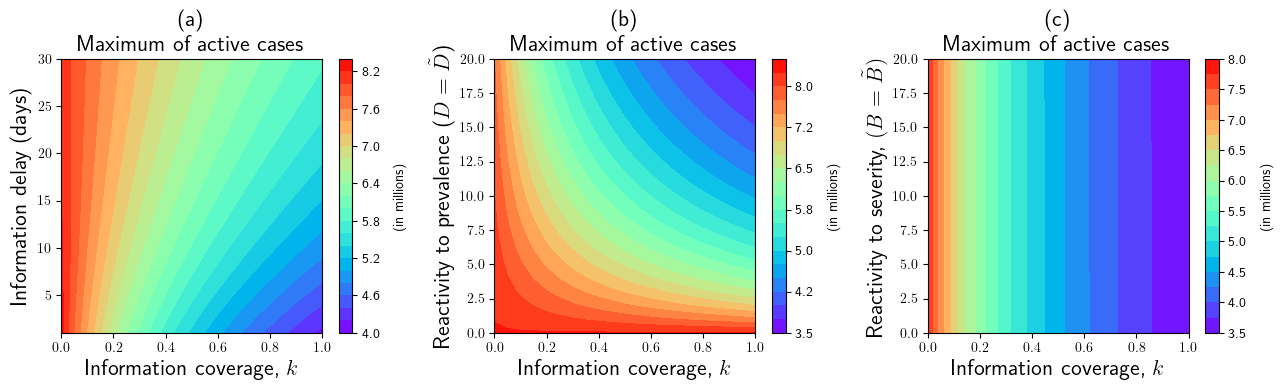

In [8]:
def millions_formatter(x, pos):    
    return f'{(x / 1000000):.1f}'
fig, axs = plt.subplots(1,3,figsize=(13,4))
axs[0].set_ylabel(r'Information delay (days)',fontsize=16)
axs[0].set_xlabel(r'Information coverage, $k$',fontsize=16)
axs[0].set_title('(a) \n Maximum of active cases',fontsize=16)
img = axs[0].contourf(P2_values,P1_values,Max_infected11.T,20,cmap = 'rainbow')
cbar = plt.colorbar(img)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
cbar.set_label('(in millions)', rotation= -270, labelpad=10)

axs[1].set_ylabel(r'Reactivity to prevalence ($D=\tilde D$)',fontsize=16)
axs[1].set_xlabel(r'Information coverage, $k$',fontsize=16)
axs[1].set_title('(b) \n Maximum of active cases',fontsize=16)
img = axs[1].contourf(P2_values,Rec_values,Max_infected22.T,20,cmap = 'rainbow')
cbar = plt.colorbar(img)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
cbar.set_label('(in millions)', rotation= -270, labelpad=10)
axs[2].set_ylabel(r'Reactivity to severity, $(B = \tilde B)$',fontsize=16)
axs[2].set_xlabel(r'Information coverage, $k$',fontsize=16)
axs[2].set_title('(c) \n Maximum of active cases',fontsize=16)
img = axs[2].contourf(P2_values,Rec_values,Max_infected33.T,20,cmap = 'rainbow')
cbar = plt.colorbar(img)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
cbar.set_label('(in millions)', rotation= -270, labelpad=10)
plt.tight_layout()
plt.savefig('Contour_dt_param1_New_BB.png', dpi=600, bbox_inches='tight')
plt.show()